# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/IAD/hw08_boosting_clustering/ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [36]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
X = df.drop(columns=['salary_in_usd', 'salary'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [37]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((3755, 9), (3004, 9), (375, 9), (376, 9))

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = X_train.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]),
                               columns=encoder.get_feature_names_out(categorical_features),
                               index=X_train.index).reset_index(drop=True)

X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_features]),
                             columns=encoder.get_feature_names_out(categorical_features),
                             index=X_val.index).reset_index(drop=True)

X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]),
                              columns=encoder.get_feature_names_out(categorical_features),
                              index=X_test.index).reset_index(drop=True)

X_train_num = X_train.drop(columns=categorical_features).reset_index(drop=True)
X_val_num = X_val.drop(columns=categorical_features).reset_index(drop=True)
X_test_num = X_test.drop(columns=categorical_features).reset_index(drop=True)

X_train_final = pd.concat([X_train_num, X_train_encoded], axis=1)
X_val_final = pd.concat([X_val_num, X_val_encoded], axis=1)
X_test_final = pd.concat([X_test_num, X_test_encoded], axis=1)

In [39]:
model = LinearRegression()
model.fit(X_train_final, y_train)

y_pred_val = model.predict(X_val_final)
y_pred_test = model.predict(X_test_final)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Validation MAPE: {mape_val:.4f}, RMSE: {rmse_val:.2f}")
print(f"Test MAPE: {mape_test:.4f}, RMSE: {rmse_test:.2f}")

Validation MAPE: 0.4302, RMSE: 46842.08
Test MAPE: 0.3733, RMSE: 51564.90


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [40]:
%%time
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'gamma': [0.1, 0.5, 1]
}


xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train_final, y_train)
y_pred = xgb.predict(X_test_final)
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) )
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE:  0.34139853715896606
RMSE:  52230.90885672965
CPU times: user 887 ms, sys: 46.9 ms, total: 934 ms
Wall time: 888 ms


In [41]:
%%time
grid_search = GridSearchCV(xgb,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_val_final, y_val)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"RMSE: {-grid_search.best_score_}")

Лучшие параметры: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
RMSE: 48716.3671875
CPU times: user 2.47 s, sys: 274 ms, total: 2.74 s
Wall time: 2min 4s


In [42]:
%%time
best_model = XGBRegressor(
    gamma=0.1,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=400,
    objective='reg:squarederror',
    random_state=42
)
best_model.fit(X_train_final, y_train)

CPU times: user 1.52 s, sys: 10.9 ms, total: 1.53 s
Wall time: 822 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
%%time
y_pred_test = best_model.predict(X_test_final)

CPU times: user 52.5 ms, sys: 1.96 ms, total: 54.5 ms
Wall time: 52.4 ms


In [44]:
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test MAPE: {mape_test:.4f}, RMSE: {rmse_test:.2f}")

Test MAPE: 0.3676, RMSE: 50535.15


Обучение модели XGB заняло около 1.21 секунды

Время предсказания на тестовой выборке составило примерно 0.07 секунды

Итоговая модель с параметрами показала лучшее качество, чем линейная регрессия

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [45]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [46]:
%%time
from catboost import CatBoostRegressor

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05],
    'iterations': [200, 400, 600],
    'l2_leaf_reg': [1, 3, 5]
}

cat = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
    verbose=0
)

cat.fit(X_train_final, y_train)
y_pred = cat.predict(X_test_final)
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) )
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE:  0.3376478855672387
RMSE:  50170.95544307299
CPU times: user 2.82 s, sys: 750 ms, total: 3.57 s
Wall time: 2.91 s


In [47]:
%%time
grid_search = GridSearchCV(cat,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_val_final, y_val)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"RMSE: {-grid_search.best_score_}")

Лучшие параметры: {'depth': 3, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
RMSE: 48215.54482772059
CPU times: user 1.51 s, sys: 235 ms, total: 1.75 s
Wall time: 1min 30s


In [48]:
%%time
best_model = CatBoostRegressor(
    depth=3,
    iterations=600,
    l2_leaf_reg=1,
    learning_rate=0.01,
    loss_function='RMSE',
    random_state=42,
    verbose=0
)
best_model.fit(X_train_final, y_train)

CPU times: user 924 ms, sys: 143 ms, total: 1.07 s
Wall time: 574 ms


In [49]:
%%time
y_pred_test = best_model.predict(X_test_final)

CPU times: user 7.2 ms, sys: 18 µs, total: 7.22 ms
Wall time: 8.55 ms


In [50]:
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test MAPE: {mape_test:.4f}, RMSE: {rmse_test:.2f}")

Test MAPE: 0.3772, RMSE: 50934.18


Обучение модели заняло около 2.1 секунды

Предсказание на тестовой выборке очень быстрое 9 миллисекунд

Итоговое качество модели немного хуже, чем у XGB, но всё ещё лучше линейной регрессии

Из коробки модель лучше работает чем с подбором гиперпараметров в данном случае

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [51]:
from catboost import Pool

cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

cat = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
    verbose=0
)

cat.fit(train_pool)
y_pred = cat.predict(test_pool)
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) )
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE:  0.34288117942078417
RMSE:  49305.98521104237


In [52]:
%%time
cat = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
    cat_features = cat_features,
    verbose=0
)
grid_search = GridSearchCV(cat,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_val, y_val)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"RMSE: {-grid_search.best_score_}")

Лучшие параметры: {'depth': 3, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
RMSE: 47709.44387249168
CPU times: user 2.58 s, sys: 328 ms, total: 2.91 s
Wall time: 3min 44s


In [53]:
%%time
best_model = CatBoostRegressor(
    depth=3,
    iterations=600,
    l2_leaf_reg=1,
    learning_rate=0.01,
    loss_function='RMSE',
    random_state=42,
    verbose=0
)
best_model.fit(train_pool)

y_pred_test = best_model.predict(test_pool)

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test MAPE: {mape_test:.4f}, RMSE: {rmse_test:.2f}")

Test MAPE: 0.3869, RMSE: 50690.51
CPU times: user 2.02 s, sys: 204 ms, total: 2.23 s
Wall time: 1.18 s


**Ответ:** #

По сравнению с запусками без использования Pool и явного указания категориальных признаков, качество модели улучшилось

Использование Pool и cat_features повысило качество





## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [54]:
from lightgbm import LGBMRegressor

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'num_leaves': [31, 50],
    'reg_lambda': [0, 1, 3]
}

lgbm = LGBMRegressor(objective='RMSE', random_state=42)
lgbm.fit(X_train_final, y_train)
y_pred = lgbm.predict(X_test_final)
print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred) )
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
MAPE:  0.31812862334103365
RMSE:  49711.57651824243


In [55]:
%%time
grid_search = GridSearchCV(lgbm,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_val_final, y_val)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"RMSE: {-grid_search.best_score_}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 19
[LightGBM] [Info] Start training from score 132017.408000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [56]:
%%time
best_params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 600,
    'num_leaves': 31,
    'reg_lambda': 0,
    'objective': 'regression',
    'random_state': 42
}

model = LGBMRegressor(**best_params, verobse = 0)

model.fit(X_train_final, y_train)

[LightGBM] [Warning] Unknown parameter: verobse
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verobse
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=600,
              objective='regression', random_state=42, reg_lambda=0, verobse=0)

In [57]:
%%time
y_pred = model.predict(X_test_final)

[LightGBM] [Warning] Unknown parameter: verobse
CPU times: user 9.71 ms, sys: 0 ns, total: 9.71 ms
Wall time: 9.5 ms


In [58]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE на тесте: {mape:.4f}")
print(f"RMSE на тесте: {rmse:.2f}")

MAPE на тесте: 0.3428
RMSE на тесте: 50158.59


Обучение модели LightGBM заняло около 2.3 секунд, а время предсказания на тестовой выборке составило примерно 12 миллисекунд. Качество модели по метрикам примерно такое же как у CatBoost и XGBoost

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

1. Качество моделей
      	              MAPE	    RMSE
          XGBoost	  ~0.34	  ~50 535

          CatBoost1	~0.38	  ~50 178

          CatBoost2	~0.37	  ~49 300

          LightGBM	~0.31	  ~49 700

Дучше всех себя показала LightGBM


2. Скорость обучения и предсказания у всех примерно одинаковое низкое

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [59]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 1001 entries, user to yellowcard
dtypes: float64(1000), int64(1)
memory usage: 38.2 MB


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [61]:
ratings_t = ratings.drop(columns = 'user').T
ratings_t.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [62]:
ratings_t = ratings.drop(columns = 'user').T
ratings_t.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [63]:
ratings = ratings_t.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
franke sinatra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [64]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)

labels_df = pd.DataFrame({'artist': ratings.index, 'clust': kmeans.labels_})
labels_df.head()

,artist,clust
0,the beatles,4
1,radiohead,0
2,deathcab for cutie,0
3,coldplay,0
4,modest mouse,0


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [65]:
clust_size = labels_df['clust'].value_counts().to_frame('size')
clust_size

,size
clust,
3,882
0,115
4,1
2,1
1,1


**Ответ:** #

Кластеры получились несбалансированными
один большой кластер включает большинство исполнителей, а остальные отдельных и возможно единичных исполнителей

Скорее всего данные очень разрежены и поэтому всех исполнителей в один кластер пихают



## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [66]:
size_one = clust_size[clust_size['size'] == 1].index
labels_df[labels_df['clust'].isin(size_one)]

,artist,clust
0,the beatles,4
10,niИ,2
931,日dir en grey,1


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [67]:
listener_counts = (ratings > 0).sum(axis=1) / ratings.shape[1]

listener_counts.sort_values(ascending=False).head(10)

,0
the beatles,0.3342
radiohead,0.2778
deathcab for cutie,0.1862
coldplay,0.1682
modest mouse,0.1628
sufjan stevens,0.1292
dylan. bob,0.1262
red hot clili peppers,0.1258
pink fluid,0.1256
kanye west,0.1250


In [68]:
avg_listen = ratings.mean(axis=1).sort_values(ascending=False).head(10)
avg_listen

,0
the beatles,0.018369
radiohead,0.011851
deathcab for cutie,0.006543
niИ,0.006470
coldplay,0.006030
modest mouse,0.005876
sufjan stevens,0.004969
dylan. bob,0.004963
pink fluid,0.004909
elliotte smith,0.004842


**Ответ:** #

the beatles выделяются потому что их слушают больше всех пользователей и средняя доля прослушиваний у них выше, чем у других исполнителей

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [69]:
from sklearn.preprocessing import normalize

ratings_norm = pd.DataFrame(
    normalize(ratings, axis=1),
    index=ratings.index,
    columns=ratings.columns
)

ratings_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [70]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings_norm)

norm_df = pd.DataFrame({'artist': ratings.index, 'clust': kmeans.labels_})
norm_df = norm_df.set_index('artist')
norm_df.head()

,clust
artist,
the beatles,3
radiohead,4
deathcab for cutie,1
coldplay,1
modest mouse,4


In [71]:
clust_size = norm_df['clust'].value_counts().to_frame('size')
clust_size

,size
clust,
4,486
1,162
3,140
2,133
0,79


**Ответ** #
Размеры кластеров увеличились и теперь она может стать более полезной, чтобы понять что ещ может понравитсья пользователям

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [72]:
from scipy.spatial.distance import cosine

centroids = kmeans.cluster_centers_

for i, center in enumerate(centroids):
    distances = ratings_norm.apply(lambda x: cosine(x, center), axis=1)
    top_10 = distances.sort_values().head(10)
    print(f'Кластер {i}:')
    display(top_10)
    print('-------------------------')

Кластер 0:


,0
nas,0.463886
jay-z,0.495511
kanye west,0.520057
lupe the gorilla,0.583878
a tribe called quest,0.586652
the roots featuring d'angelo,0.593835
gangstarr,0.627951
little brother,0.629114
lil' wayne,0.632561
murs and 9th wonder,0.635230


-------------------------
Кластер 1:


,0
fall out boy,0.634882
the all-americian rejects,0.655979
paramore,0.658733
kelly clarkson,0.664350
john mayer,0.674993
the fray,0.675170
maroon5,0.688339
dashboard confesssional,0.690969
somethings corporate,0.710460
coldplay,0.711482


-------------------------
Кластер 2:


,0
brand new,0.630789
blink-182,0.655546
alkaline trio,0.663157
against me!,0.665646
underoath,0.699969
descendents,0.701055
new found glory,0.702068
less than jake,0.705504
thrice,0.706222
chiodos,0.712410


-------------------------
Кластер 3:


,0
the beatles,0.620316
the rolling stones,0.623515
dylan. bob,0.656529
who,0.698215
led zeppelin.,0.707519
miles davis.,0.720636
simon and garfunkel,0.727295
"young, neil",0.731910
pink fluid,0.732046
velvet underground,0.744756


-------------------------
Кластер 4:


,0
radiohead,0.589214
the arcade fire,0.670243
the shins,0.695119
sufjan stevens,0.696286
belle and sebastian,0.706782
broken social scene,0.707001
the pixies,0.707969
animal collective,0.714135
modest mouse,0.720852
spoon,0.722582


-------------------------


**Ответ:** #

Кластеры группируют исполнителей по жанрам

Например, в одном кластере — рое, в другом — альтернативный рок, а в третьем — поп

Кластеризация помогает выявить общие музыкальные предпочтения и использовать это для рекомендаций



## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

ratings_norm = ratings_norm.join(norm_df)

In [74]:
ratings_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,clust
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000,3
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000,4
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622,1
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4


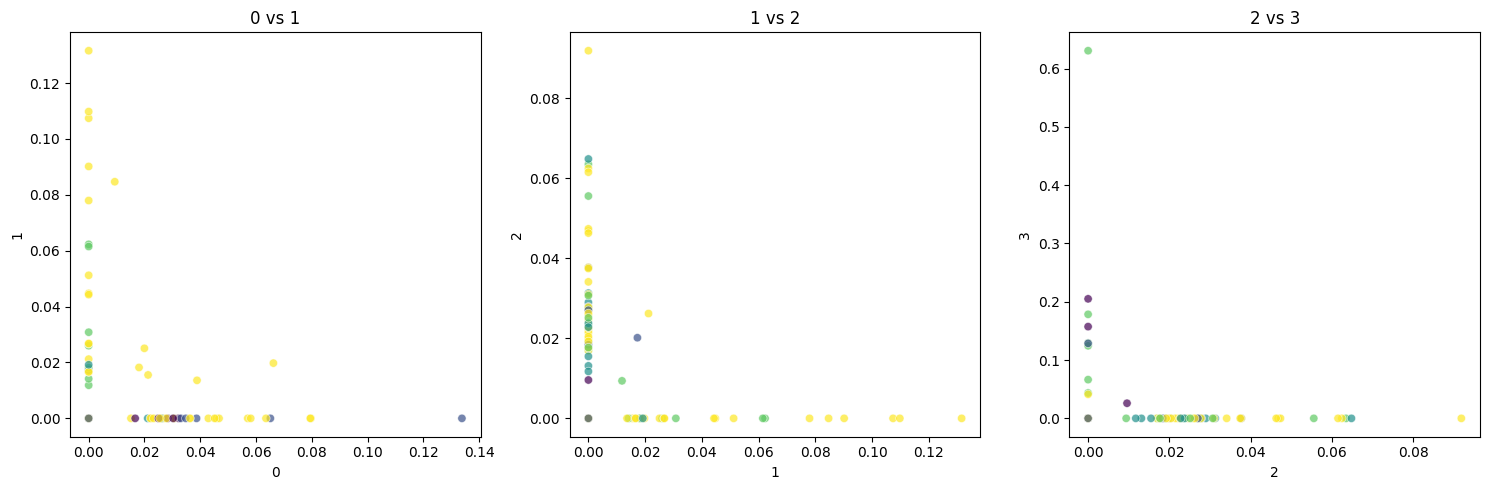

In [75]:
feature_pairs = [(0, 1), (1, 2), (2, 3)]

fig, axs = plt.subplots(1, len(feature_pairs), figsize=(15, 5))

for i, (feat_x, feat_y) in enumerate(feature_pairs):
    sns.scatterplot(
        ax=axs[i],
        x=ratings_norm[feat_x],
        y=ratings_norm[feat_y],
        hue=ratings_norm['clust'],
        palette='viridis',
        alpha=0.7,
        legend=False
    )
    axs[i].set_xlabel(f'{feat_x}')
    axs[i].set_ylabel(f'{feat_y}')
    axs[i].set_title(f'{feat_x} vs {feat_y}')
plt.tight_layout()
plt.show()

**Ответ:**

Визуализации получились такими, потому что пары признаков не отражают разделение кластеров в многомерном пространстве

При большом числе  признаков реальные границы между кластерами сложно увидеть на простых двухмерных проекциях

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
results = tsne.fit_transform(ratings_norm.drop(columns = 'clust').values)

tsne = pd.DataFrame(results, index=ratings_norm.index, columns=['TSNE1', 'TSNE2'])
tsne['clust'] = ratings_norm.clust

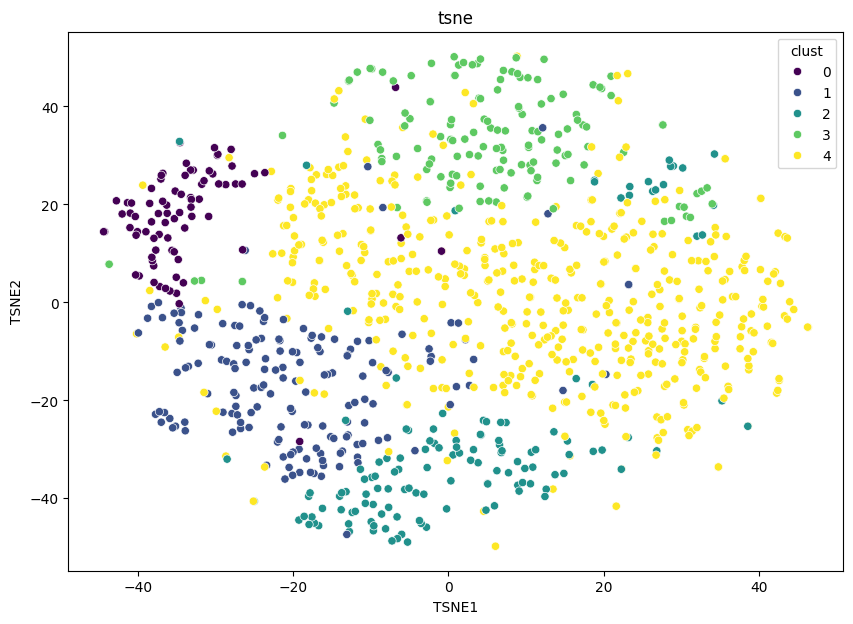

In [77]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='clust',
    palette='viridis',
    data=tsne
)
plt.title('tsne')
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [78]:
ratings_norm = ratings_norm.drop(columns = 'clust')

In [79]:
from sklearn.metrics import silhouette_score

max_clusters = 100
best_score = -10000000000
best_k = 0

for k in range(70, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(ratings_norm)
    score = silhouette_score(ratings_norm, labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Лучшее количество кластеров: {best_k} с индексом Силуэта: {best_score:.4f}")

Лучшее количество кластеров: 98 с индексом Силуэта: 0.0133


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [80]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(ratings_norm)

norm_df = pd.DataFrame({'artist': ratings.index, 'clust': kmeans.labels_})
norm_df = norm_df.set_index('artist')

centroids = kmeans.cluster_centers_

for i, center in enumerate(centroids):
    distances = ratings_norm.apply(lambda x: cosine(x, center), axis=1)
    top_10 = distances.sort_values().head(10)
    print(f'Кластер {i}:')
    display(top_10)
    print('-------------------------')

Кластер 0:


,0
dr. dre,0.451205
the faint,0.523073
violent femmes,0.541796
margot and the nuclear so and sos,0.542441
owen,0.552288
the bloodhound gang,0.569399
cursive,0.834790
van hallen,0.853426
bright eyes,0.884776
ironand wine,0.910473


-------------------------
Кластер 1:


,0
john mayer,0.470144
matt nathanson,0.495609
gavin degraw,0.562061
jason mraz,0.576486
ray lamontagne,0.592266
joshua radin,0.597702
sara bareilles,0.611662
augustana,0.619524
maroon5,0.651694
o.a.r.,0.712297


-------------------------
Кластер 2:


,0
white stripes,0.476102
beck,0.607384
the raconteurs,0.608539
spoon,0.609608
the pixies,0.629787
the strokes,0.643976
the flaming lips,0.657387
cake,0.666424
black rebel motorcycle club,0.672786
gorillaz,0.679027


-------------------------
Кластер 3:


,0
fugazi,0.463915
jawbreaker,0.540241
sleater-kinney,0.607036
les savy fav,0.613600
capn jazz,0.617177
bad brains,0.620151
blonde redhead,0.637851
propagandhi,0.649322
the melvins,0.685452
gogol bordello,0.699829


-------------------------
Кластер 4:


,0
ryan adams,0.510370
band of horses,0.528710
ryan adams and the cardinals,0.607589
rogue wave,0.619857
my morning jacket,0.634208
matt pond pa,0.642811
cloud cult,0.643064
the american analog set,0.656299
nada surf,0.664201
tv on the radio,0.678082


-------------------------
Кластер 5:


,0
dj shadow,0.452265
rjd2,0.563461
amon tobin,0.628508
jedi mind tricks,0.630351
el-p,0.640109
aphex twin,0.651605
sublime,0.672544
moby*,0.683351
gnarls barkley,0.687191
soul coughing,0.706504


-------------------------
Кластер 6:


,0
system of a down,0.438939
koЯn,0.445374
mudvayne,0.486951
limpt bizkit,0.540237
disturbed,0.578616
slipknot,0.597929
papa roach,0.612005
godsmack,0.626345
marilyn manson,0.638950
fort minor,0.655927


-------------------------
Кластер 7:


,0
somethings corporate,0.342768
the rocket summer,0.421176
jack’s mannequin,0.437914
cartel,0.456385
the format,0.486444
travis,0.668102
keane,0.752586
the starting line,0.752879
motion city soundtrack,0.772960
dashboard confesssional,0.773782


-------------------------
Кластер 8:


,0
chiodos,0.376124
underoath,0.376579
scary kids scaring kids,0.379726
saosin,0.468528
norma jean,0.501761
from first to last,0.550926
from autumn to ashes,0.562924
alexisonfire,0.581833
the red jumpsuit apparatus,0.619495
a day to remember,0.627846


-------------------------
Кластер 9:


,0
the police,0.394377
peter gabriël,0.461710
r.e.m.,0.480759
bush,0.512267
sade,0.579836
sting,0.819561
pearl jam,0.825638
u2,0.842981
genesis,0.866080
phill collins-,0.871490


-------------------------
Кластер 10:


,0
j dilla,0.361350
the loopdigga,0.428458
mf doom & madlib as madvillain,0.461575
quasimoto,0.535809
flying lotus,0.544555
mf doom,0.551065
busta rhymes,0.663138
a tribe called quest,0.696927
rx bandits,0.715924
prince,0.716943


-------------------------
Кластер 11:


,0
alicia keys,0.425372
mary j. blige,0.460101
aaliyah,0.478053
janet jackson.,0.494571
destinys child,0.499592
scott jill,0.533432
erykah badu,0.561444
laurуn hill,0.599462
missy elliott,0.623195
corinne bailey rae,0.670493


-------------------------
Кластер 12:


,0
sufjan stevens,0.471834
the arcade fire,0.551591
the shins,0.563853
beirut,0.581644
ironand wine,0.595686
andrew bird,0.596846
broken social scene,0.604594
the decemberists,0.621215
deathcab for cutie,0.624267
bon iver,0.661647


-------------------------
Кластер 13:


,0
digitalism,0.437731
the rapture,0.502176
cut copy,0.512137
lcd soundsystem,0.513146
hot chip,0.539243
crystal castles,0.540518
chromeo,0.597967
justice,0.615016
fischerspooner,0.627446
the klaxons,0.633616


-------------------------
Кластер 14:


,0
john lenon,0.479676
the byrds,0.485280
simon and garfunkel,0.500822
paul mcmartney,0.507433
george harrison and friends,0.512402
donovan,0.600023
the beach boys,0.642174
cream,0.671045
the bee gees,0.675760
jeffterson airplane,0.687157


-------------------------
Кластер 15:


,0
chris brown,0.315362
t-pain,0.418722
usher,0.423312
kanye west,0.430776
john legend,0.501423
ne-yo,0.505336
lil' wayne,0.711371
jay-z,0.718769
ludacris,0.752194
mary j. blige,0.762344


-------------------------
Кластер 16:


,0
3oh!3,0.330291
cute is what we aim for,0.429697
forever the sickest kids,0.448236
mayday parade,0.456855
metro station,0.500951
hawthorne heights,0.627668
owl city,0.648207
jonas brothers,0.695681
passion pit,0.724008
all time low,0.729768


-------------------------
Кластер 17:


,0
the cure,0.501147
the smiths,0.503697
new order,0.530566
morrissey,0.561949
depeche Мode,0.562372
echo and the bunnymen,0.573149
oy division,0.573607
siouxsie and the banshees,0.603300
cocteau twins,0.645191
erasure,0.672846


-------------------------
Кластер 18:


,0
van hallen,0.462859
acdc,0.557001
aerosmith,0.598718
ozzy osbourne,0.603535
rush,0.605205
led zeppelin.,0.609907
queensrÿche,0.616566
kizz,0.625659
dream theater,0.639319
gunsnroses,0.668978


-------------------------
Кластер 19:


,0
deerhunter,0.429159
animal collective,0.486270
liars,0.549371
no age,0.573661
grizzly bear,0.578157
beach house,0.609277
deerhoof,0.631877
silver jews,0.666638
daniel johnston,0.685707
caribou,0.688996


-------------------------
Кластер 20:


,0
pelican,0.349435
65daysofstatic,0.466899
god is an astronaut,0.531672
black moth super rainbow,0.573052
lin que,0.575147
...and you will know us by the trail of dead,0.615477
murder by death,0.641036
refused,0.698444
explosions in the sky,0.750020
mogwai,0.764983


-------------------------
Кластер 21:


,0
newsboys,0.325523
jars of clay,0.384015
switchfoot,0.427767
michal w. smith,0.429801
david crowder*band,0.441975
chris tomlin,0.455227
skillet,0.485134
relient k,0.509165
mutemath,0.639973
trans-siberian orchestra,0.745913


-------------------------
Кластер 22:


,0
the goo goo dools,0.382135
evril lavigne,0.496958
nelly furtado,0.508564
no doubt,0.556389
lifehouse,0.583104
duran duran,0.609930
collective soul,0.666285
rachael yamagata,0.765309
daughtry,0.846686
kelly clarkson,0.851199


-------------------------
Кластер 23:


,0
sum41,0.386720
reel big fish,0.455431
sugarcult,0.474558
goldfinger,0.520250
good charlotte,0.523471
bowling for soup,0.527182
rise against,0.590466
less than jake,0.633924
blink-182,0.714626
new found glory,0.774670


-------------------------
Кластер 24:


,0
coconut records,0.313085
why?,0.407884
tokyo police club,0.500323
yeah yeah yeahs,0.546587
au rivoir simone,0.574246
conor oberst,0.575550
bright eyes,0.816045
cut copy,0.881977
band of horses,0.883092
tv on the radio,0.887362


-------------------------
Кластер 25:


,0
soundgarden,0.335374
alice in chains,0.376889
stone temple pilots,0.417827
nirvana*,0.451554
civilian,0.486399
blind melon,0.597037
bush,0.752530
pearl jam,0.772080
the smashing pumpkins,0.842425
foo fighters,0.865866


-------------------------
Кластер 26:


,0
as i lay dying,0.359766
all that remains,0.366401
killswitch engage,0.441237
bullet for my valintine,0.475959
atreyu,0.481494
|avenged sevenfold,0.534614
between the buried and me,0.587645
bring me the horizon,0.607170
the black dahlia murder,0.676923
the dillinger escape plan,0.696801


-------------------------
Кластер 27:


,0
kelly clarkson,0.412603
michelle branch,0.583915
ingrid michaelson,0.628814
colbie caillat,0.631662
missy higgins,0.653444
the fray,0.656008
nsync,0.669060
natasia beddingfield,0.672325
indigo girlz,0.674094
timbaland presents onerepublic,0.676461


-------------------------
Кластер 28:


,0
eminem,0.369210
50 cent,0.517722
tupak shakur,0.594924
m.i.a.,0.604574
immortal technique,0.627096
chamillionaire,0.639637
silverstein,0.668305
elvish presley,0.690548
straylight run,0.700601
the game,0.764051


-------------------------
Кластер 29:


,0
lynyrd skynyrd-,0.360665
eric clapton,0.549251
tom petty and the heartbreakers,0.562408
venetian snares,0.579265
fear factory,0.606993
the allman brothers band,0.637514
the eagles,0.642214
hank williams,0.649111
timi hendrix,0.653291
the rolling stones,0.831966


-------------------------
Кластер 30:


,0
alkaline trio,0.431153
saves the day,0.526397
the get up kids,0.537031
the lawrence arms,0.565891
hot water music,0.579015
against me!,0.602678
lifetime,0.610643
thrice,0.641912
lucero,0.663658
the ataris,0.666472


-------------------------
Кластер 31:


,0
nofx,0.418886
the bouncing souls,0.479030
rancid,0.486396
bad religion,0.493124
dropkick murphys,0.544570
me first and the gimme gimmes,0.581189
descendents,0.587189
social distortion,0.642232
mxpx,0.666088
primus,0.687425


-------------------------
Кластер 32:


,0
catch 22,0.345893
streetlight manifesto,0.389208
big d and the kids table,0.393116
less than jake,0.411741
the mighty mighty bosstones,0.441074
bomb the music industry!,0.463585
anti-flag,0.601378
five iron frenzy,0.630742
reel big fish,0.695415
against me!,0.715834


-------------------------
Кластер 33:


,0
prefuse 73,0.443023
boards of canada,0.459818
squarepusher.,0.476327
autechre,0.512370
the books,0.554864
four tet,0.598642
underworld,0.604733
the avalanches,0.643383
junior boys,0.668315
aphex twin,0.730526


-------------------------
Кластер 34:


,0
tricky & dj muggs & grease,0.378710
massive attack,0.460036
portishead,0.471419
lamb,0.481081
30 seconds to mars,0.571028
flyleaf,0.590283
goldfrapp,0.602562
orbital,0.666662
sneaker pimps,0.735772
seether,0.777267


-------------------------
Кластер 35:


,0
dylan. bob,0.457543
the rolling stones,0.540192
"young, neil",0.565998
the beatles,0.589935
the gateful dead,0.602668
bruce springsteen,0.662568
velvet underground,0.664040
van morrison,0.668249
the band,0.672234
creedence clearwater rival,0.682982


-------------------------
Кластер 36:


,0
built to spill,0.430274
sebadoh,0.511768
the thermals,0.514928
the blow,0.518633
pavement,0.523537
blur,0.621558
dr. dog,0.636390
dinosaur jr.,0.768447
the replacements,0.807210
the pixies,0.818877


-------------------------
Кластер 37:


,0
danzig,0.444346
the cramps,0.497305
patton oswalt,0.512479
nick cave and the bad seeds,0.563560
bauhaus,0.565223
rob zombie,0.598762
"cooper, alice",0.605629
eagles of death metal,0.616679
mötley crüe,0.702951
siouxsie and the banshees,0.805932


-------------------------
Кластер 38:


,0
lady gaga,0.387456
brritney spears,0.549603
tatu,0.567920
pink*,0.576783
madonna,0.591039
veronicas,0.614587
timbaland,0.651923
tori amos,0.652381
kylie minogue,0.661441
shakira,0.691557


-------------------------
Кластер 39:


,0
arch enemy,0.324030
sonata arctica1,0.395805
lacuna coil[,0.412726
mitch hedberg,0.541948
nightwish[,0.728065
dane cook,0.735786
iced eatrth,0.754248
cob,0.774646
amon amarth,0.784102
dragonforce,0.784396


-------------------------
Кластер 40:


,0
sigur rós,0.486819
mogwai,0.569634
explosions in the sky,0.585665
do make say think,0.602231
radiohead,0.603610
"godspeed you!, black emperor",0.628028
the album leaf,0.630454
m83,0.649030
eluvium,0.656327
múm,0.661912


-------------------------
Кластер 41:


,0
the temptations,0.336934
curtis mayfield,0.379679
matvin gaye,0.382824
sly & the family stone,0.385103
james brown,0.509907
otis redding,0.651804
r. kelly,0.657239
prince,0.836106
al green,0.840366
stevie wonder,0.846922


-------------------------
Кластер 42:


,0
gillian welch,0.282886
townes van zandt,0.480949
old crow medicine show,0.506105
alison krauss & union station,0.539296
neko case,0.542954
jethro tull,0.591082
josh ritter,0.643034
flogging molly,0.660286
the pogues,0.867408
dropkick murphys,0.871794


-------------------------
Кластер 43:


,0
iggy pop,0.392808
divid bowie,0.505361
t.rex,0.531908
the b-52s,0.555600
beck*,0.631971
jeff buckley,0.640281
the aquabats!,0.641361
velvet underground,0.799236
the rolling stones,0.825781
minutemen,0.846038


-------------------------
Кластер 44:


,0
shinedown,0.239693
līve,0.239693
breaking benjamin,0.839892
stone temple pilots,0.848625
three days grase,0.855767
pearl jam,0.856963
nickelback,0.862399
bush,0.863788
daughtry,0.864200
the killers,0.870752


-------------------------
Кластер 45:


,0
circa survive,0.485487
portugal. the man,0.499457
the fall of troy,0.552895
thursday,0.594115
fear before the march of flames,0.598638
cursive,0.607816
the blood brothers,0.615876
every time i die,0.626953
mewithoutyou,0.649952
citya and colour,0.669350


-------------------------
Кластер 46:


,0
casiotone for the painfully alone,0.465816
akron/family,0.547731
kimya dawson,0.568457
the mountain goats,0.573218
the microphones,0.573918
grandaddy,0.636972
old 97s,0.657128
freezepop,0.668154
joanna newsom,0.830517
animal collective,0.839002


-------------------------
Кластер 47:


,0
paul van dyk,0.303706
tiësto,0.345188
atb,0.441317
armin van buuren,0.477641
bt,0.478649
paul oakenfold,0.500081
infected mushroom,0.677531
the crystal method,0.678007
moby,0.690591
fatboy slim,0.691621


-------------------------
Кластер 48:


,0
cob,0.350644
iced eatrth,0.490126
amon amarth,0.496224
dimmu borgir,0.506131
dragonforce,0.530012
in flames,0.538345
kamelot,0.565075
nightwish[,0.609670
sonata arctica1,0.682006
lamb of god,0.684238


-------------------------
Кластер 49:


,0
fall out boy,0.401437
the academy is...,0.517530
cobra starship,0.574416
taking back sunday,0.588655
paramore,0.589707
all time low,0.591497
the all-americian rejects,0.596067
motion city soundtrack,0.612891
the used,0.614006
the starting line,0.619489


-------------------------
Кластер 50:


,0
hüsker dü,0.377855
sonic youth,0.500903
minutemen,0.541499
gang of four,0.556693
butthole surfers,0.563956
the replacements,0.573686
wire,0.587317
dinosaur jr.,0.619000
the fall,0.643498
ween,0.678417


-------------------------
Кластер 51:


,0
comeback kid,0.297926
set your goals,0.358498
ceremony,0.394991
mc chris,0.549183
converge,0.552271
new found glory,0.783160
four year strong,0.793352
a day to remember,0.854649
lifetime,0.859012
the dillinger escape plan,0.867500


-------------------------
Кластер 52:


,0
blackalicious,0.366858
people under the staris,0.495659
jurassic 5,0.514133
aesop rock,0.537243
deltron 3030,0.582136
saul williams,0.588773
the chemical brothers,0.626032
del the funky homosapien,0.723028
a tribe called quest,0.752794
the roots featuring d'angelo,0.769263


-------------------------
Кластер 53:


,0
death,0.352538
opeth,0.454761
meshuggah,0.518370
dëthkløk,0.531545
agalloch,0.531610
jonathan coulton,0.600689
amon amarth,0.782766
in flames,0.797382
cannibal corpse,0.814802
dimmu borgir,0.849504


-------------------------
Кластер 54:


,0
slayer,0.380724
iron maiden,0.429629
megadeth,0.485705
metallica,0.495232
judas priest,0.508355
black sabbath,0.512545
pantera,0.600020
municipal waste,0.628039
motörhead,0.644671
blind guardian,0.691494


-------------------------
Кластер 55:


,0
kate nash,0.418098
the ting tings,0.517878
she & him,0.520460
adele,0.574560
lykke li,0.575421
sia,0.582511
the sounds,0.625348
mika,0.836461
a fine frenzy2,0.842353
feist,0.847044


-------------------------
Кластер 56:


,0
the killers,0.463632
coldplay,0.552816
muse,0.615283
keane,0.650014
phoenix,0.657491
rooney,0.657924
ok go,0.663927
kings of leon,0.669791
the postal service,0.678488
the bravery,0.683138


-------------------------
Кластер 57:


,0
phill collins-,0.405401
sting,0.597144
inxs,0.605432
electric light orchestra,0.615674
tears forfears,0.617591
chicago,0.618525
eltron john,0.621728
genesis,0.624391
man man,0.671415
foals,0.683039


-------------------------
Кластер 58:


,0
the zombies,0.465158
the kinks,0.513463
lou reed,0.564873
who,0.571113
captain beefhearth & his magic band,0.600216
the jesus and mary chain,0.628127
buddy holly,0.643672
sam cooke,0.669847
velvet underground,0.678315
the rolling stones,0.775218


-------------------------
Кластер 59:


,0
the libertines,0.441508
bloc party,0.529872
patrick wolf,0.591796
the editors,0.593784
the fratellis,0.608465
placebo,0.617162
los campesinos!,0.629319
doves,0.649722
the verve,0.651667
the arctic monkeys,0.712025


-------------------------
Кластер 60:


,0
johnson jack,0.438483
ben harper,0.487175
citizen cope,0.488442
dave matthews band,0.579504
dispatch,0.601578
nowa jones,0.639636
kt tunstall,0.649972
slightly stoopid,0.667641
pepper,0.707742
john mayer,0.814425


-------------------------
Кластер 61:


,0
gza/genius,0.287943
raekwon,0.397569
wu-tang clan,0.436665
cypress hill,0.521399
bob marleythe wailers,0.600468
del the funky homosapien,0.607301
sondre lerche,0.681189
akira yamaoka,0.719679
gangstarr,0.771443
a tribe called quest,0.798777


-------------------------
Кластер 62:


,0
the ramones,0.411691
the clash,0.581837
the buzzcocks,0.593020
the misfits,0.605757
screeching weasel,0.622167
black flag,0.628537
the black lips,0.645200
operation ivy,0.664619
dead kennedys,0.671628
the sex pistols,0.676748


-------------------------
Кластер 63:


,0
belle and sebastian,0.449930
the magnetic fields,0.578514
jens lekman,0.587358
of montreal,0.599983
architecture in helsinki,0.610996
camera obscura,0.637911
the stars,0.640928
neutral milk hotel,0.655675
destroyer,0.683569
bright eyes,0.686838


-------------------------
Кластер 64:


,0
duke ellington,0.393868
louıs armstrong,0.433067
Ｂille holiday,0.458968
ella fitzgerald,0.464026
nina simone,0.550563
ray charles,0.612621
morricone,0.670443
"reinhardt, django",0.687444
franklin aretha,0.691892
the band,0.783384


-------------------------
Кластер 65:


,0
little brother,0.396405
lupe the gorilla,0.414642
talib kweli,0.416313
nas,0.435751
the roots featuring d'angelo,0.457384
mos def,0.467730
common,0.568522
jay-z,0.585796
murs and 9th wonder,0.586080
kanye west,0.624611


-------------------------
Кластер 66:


,0
bill evans.,0.399201
john coltrane,0.415256
thelonious monk,0.444903
miles davis.,0.475618
mingus charles,0.478439
charlie parker,0.520712
herbie hancock,0.594746
nick drake,0.669971
glenn gould,0.723002
eno,0.725112


-------------------------
Кластер 67:


,0
asobi seksu,0.371819
slowdive,0.388352
röyksopp,0.470716
ladytron,0.497078
my bloody valentine,0.509771
broadcast,0.548115
beach house,0.824709
stereolab,0.830213
deerhunter,0.843793
animal collective,0.856972


-------------------------
Кластер 68:


,0
carrie underwood,0.369169
taylor swift,0.451966
rascal flatts,0.534806
daughtry,0.557022
the original cast,0.628634
miley cyrus,0.628767
secondhand serenade,0.634642
snow potrol,0.640182
bon jovi,0.650876
kelly clarkson,0.738983


-------------------------
Кластер 69:


,0
the pussycat dolls,0.366748
rihanna & jay-z,0.459427
fergie,0.494412
mariah carey,0.516445
beyoncé,0.519117
leona lewis,0.585562
gwen stefani,0.616981
the block eyed peas,0.629795
crustina aguilera,0.661470
マイケル・ジャクソン,0.667037


-------------------------
Кластер 70:


,0
breaking benjamin,0.331095
staind,0.470252
seether,0.471134
three days grase,0.475174
‌linkin park,0.522767
chevelle,0.542243
finger eleven,0.568120
evanescense,0.586526
lostprophets,0.650388
horse the band,0.695239


-------------------------
Кластер 71:


,0
the cardigans,0.229124
mew,0.311893
burial,0.524639
the cranberries,0.548446
jethro tull,0.853946
shpongle,0.877209
thom yorke,0.923782
radiohead,0.931589
megadeth,0.934998
flying lotus,0.938996


-------------------------
Кластер 72:


,0
ben folds,0.392025
ben folds five,0.411382
berenaked ladies,0.526264
counting crows,0.604561
guster,0.639149
everclear,0.639513
they might be giants [tmbg],0.647021
the quitters,0.675614
ben kweller,0.682107
fountains of wayne,0.684565


-------------------------
Кластер 73:


,0
Бах Иоганн Себастьян,0.307007
ВИВАЛЬДИ,0.324362
Вольфганг Амадей Моцарт,0.410210
ШОПЕН,0.493254
ルートヴィヒ・ヴァン・ベートーヴェン,0.516791
Йrik satie,0.577623
john williams (g),0.887708
miles davis.,0.912574
the original cast,0.915289
john coltrane,0.920850


-------------------------
Кластер 74:


,0
nightmares on wax?,0.406291
thievery corporation,0.484117
tosca,0.527898
the cinematic orchestra,0.531572
zero 7,0.564505
groove armada,0.590201
morcheeba,0.598882
tйlйpopmusik,0.606422
bonobo,0.639875
basement jaxx,0.644276


-------------------------
Кластер 75:


,0
direr straits,0.379278
jimmy buffett,0.430639
oingo boingo,0.483566
al green,0.506217
rush,0.794835
eric clapton,0.848529
bruce springsteen,0.878834
acdc,0.881106
u2,0.887508
r.e.m.,0.887925


-------------------------
Кластер 76:


,0
franz ferdinand,0.434006
kaiser thiefs,0.494142
the arctic monkeys,0.531370
the kooks,0.542195
hothot heat,0.574649
lily allen,0.622127
mgmt,0.659268
nouvelle vague,0.670639
css,0.710816
scissor sisters;,0.720054


-------------------------
Кластер 77:


,0
tool,0.419075
perfect circle,0.504872
niИ,0.571697
ratm,0.587297
porcupine tree,0.616736
faith no more,0.654867
shpongle,0.661471
dredg,0.666780
frank zappa (& the mothers of invention),0.694631
clutch,0.703569


-------------------------
Кластер 78:


,0
james blunt,0.294828
"rice, demien",0.383777
rachael yamagata,0.385460
various korean artists,0.581981
david gray,0.601845
cascada,0.638392
evril lavigne,0.851034
coldplay,0.868563
ray lamontagne,0.871101
ingrid michaelson,0.878892


-------------------------
Кластер 79:


,0
foo fighters,0.425227
red hot clili peppers,0.500027
incubus,0.507497
nirvana,0.560190
pearl jam,0.588000
jet,0.622518
jimmy eat world,0.627501
deftones,0.635416
oasis,0.668788
civilian,0.783821


-------------------------
Кластер 80:


,0
jewel,0.249660
﻿sarah mclachlan,0.475527
a fine frenzy2,0.489034
the early november,0.519415
dixie chicks,0.527426
dashboard confesssional,0.776712
taylor swift,0.838770
sheryl crow,0.862463
sia,0.869760
augustana,0.882959


-------------------------
Кластер 81:


,0
foreigner-,0.424440
styx,0.432808
boston,0.452575
fleetwood mac,0.580189
the cars,0.588280
journey,0.635072
duffy,0.649731
steve miller band,0.713363
보아,0.714365
the jimi hendrix experience,0.799723


-------------------------
Кластер 82:


,0
the unicorns,0.284984
islands,0.334696
panda bear,0.387636
sunset rubdown,0.483178
animal collective,0.654519
grizzly bear,0.839748
of montreal,0.856963
the arcade fire,0.857165
the pixies,0.873539
fleet foxes,0.875419


-------------------------
Кластер 83:


,0
yo la tengo,0.462148
wilco,0.546730
spiritualized®,0.570250
bonnie prince billy,0.583204
the walkmen,0.593319
the sea and cake,0.597686
guided by voices,0.613108
sparklehorse,0.623083
pavement,0.803040
m. ward,0.806868


-------------------------
Кластер 84:


,0
matchbox twenty,0.382712
nickelback,0.442621
train,0.498942
3 doors down,0.553991
creed,0.588518
eve 6,0.627687
tom petty,0.670286
ani difranco,0.689559
staind,0.778717
leona lewis,0.804991


-------------------------
Кластер 85:


,0
dido,0.262088
neil diamond,0.262088
direr straits,0.930250
miley cyrus,0.935048
paul mcmartney,0.937531
beck*,0.940547
"cooper, alice",0.941630
nsync,0.943925
eltron john,0.945275
the cranberries,0.945715


-------------------------
Кластер 86:


,0
blink-182,0.412205
brand new,0.505916
new found glory,0.541836
say anything,0.597125
armor for sleep,0.613825
plus-44,0.622866
angels and airwaves,0.636868
afi,0.665180
greenday,0.668954
taking back sunday,0.682874


-------------------------
Кластер 87:


,0
t.i.,0.324771
lil' wayne,0.437718
"ross, rick",0.444917
jay-z,0.503421
ludacris,0.514425
akon,0.521214
flo rida,0.544250
justin timberlake,0.586650
kanye west,0.593430
the game,0.610723


-------------------------
Кластер 88:


,0
can,0.318384
boc,0.364357
king crimson,0.467168
yes,0.528327
kraftwerk,0.610773
rush,0.836647
frank zappa (& the mothers of invention),0.868488
genesis,0.883125
pink fluid,0.896952
wire,0.911307


-------------------------
Кластер 89:


,0
big l,0.410619
the game,0.465942
snoop doggy dogg featuring jd,0.523857
triple 6 mafia,0.571424
ice cube,0.573766
mobb deep,0.578449
clipse,0.584081
50 cent,0.612238
the notorious b.i.g.,0.629869
nas,0.654920


-------------------------
Кластер 90:


,0
franke sinatra,0.369779
nat king cole,0.394106
walt disneys,0.513306
enya,0.536577
tim rice && andrew lloyd webb,0.557822
ella fitzgerald,0.785125
louıs armstrong,0.818175
the original cast,0.882638
john williams (g),0.889117
the block eyed peas,0.897009


-------------------------
Кластер 91:


,0
vnv nation,0.439609
kmfdm,0.467012
rammstein,0.574619
ministry,0.588412
skinny puppy,0.593532
delerium,0.614035
rasputina,0.616764
him,0.670643
niИ,0.800825
marilyn manson,0.802337


-------------------------
Кластер 92:


,0
zimmer,0.412763
lord of the rings,0.479737
john williams (g),0.504055
apocalyptica,0.604238
danny elfman,0.610852
alanis morrisette,0.613862
thomas newman,0.637021
josh groban,0.644951
micheal bublè,0.828820
trans-siberian orchestra,0.891588


-------------------------
Кластер 93:


,0
andrew jackson jihad,0.370059
dillinger four,0.452720
the glaslight anthem,0.464766
mattandkim,0.481520
wolf parade,0.582275
the lawrence arms,0.686822
against me!,0.840968
jawbreaker,0.877272
propagandhi,0.883427
lifetime,0.885046


-------------------------
Кластер 94:


,0
fiona apple,0.478025
imogen_heap,0.600061
liz phair,0.635102
the dresden dolls,0.642074
pj harvey,0.655550
mirah,0.670101
sheryl crow,0.678965
eisley,0.689427
jem,0.692228
garbage,0.694793


-------------------------
Кластер 95:


,0
de la soul,0.342377
a tribe called quest,0.374644
gangstarr,0.483286
public enemy,0.564424
￼beastie boys,0.567925
dangerdoom,0.618769
outkast,0.647898
tortoise,0.698265
jamiroquai,0.699676
the roots featuring d'angelo,0.736404


-------------------------
Кластер 96:


,0
shiny toy guns,0.285410
she wants revenge,0.354278
mika,0.515073
frou frou,0.517019
imogen_heap,0.829011
angels and airwaves,0.864254
the sounds,0.879673
no doubt,0.879783
a fine frenzy2,0.893633
pink,0.902788


-------------------------
Кластер 97:


,0
at the drive-in,0.336142
the mars volta,0.412939
lightning bolt,0.488187
battles,0.502367
sunny day real estate,0.607464
death from above 1979,0.629796
ted leo and the pharmacists,0.645491
the blood brothers,0.860552
minus the bear,0.869010
deerhoof,0.869755


-------------------------


**Ответ:** #
Теперь кластеры отражают не жанр музыки а более точный стиль музыки, например в  кластере 3 исполнители, которые известны энергичным заряженным роком, а в кластере 2 более спокойный инди рок



Сделайте t-SNE визуализацию полученной кластеризации.

In [81]:
ratings_norm = ratings_norm.join(norm_df)

In [82]:
tsne = TSNE(n_components=2, random_state=42)
results = tsne.fit_transform(ratings_norm.drop(columns = 'clust').values)

tsne = pd.DataFrame(results, index=ratings_norm.index, columns=['TSNE1', 'TSNE2'])
tsne['clust'] = ratings_norm.clust


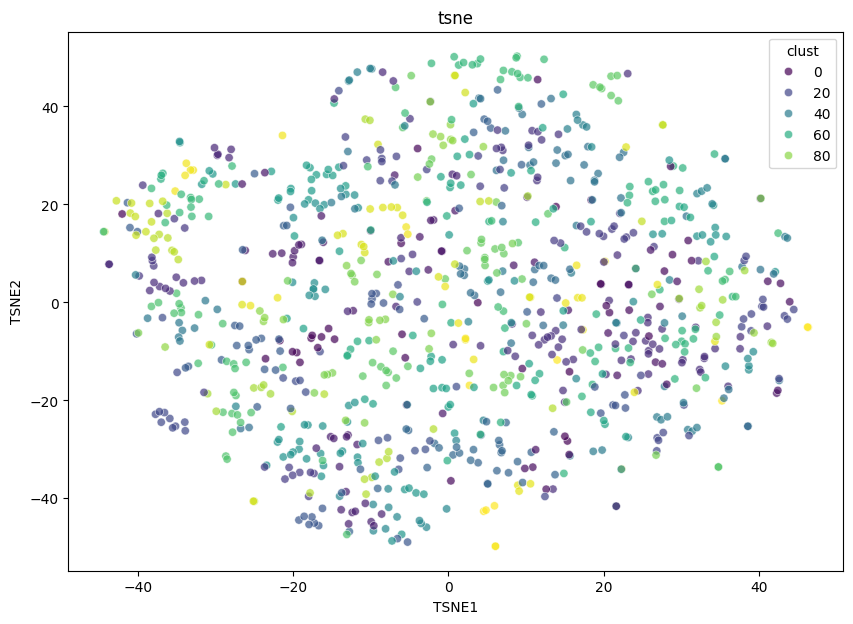

In [83]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='clust',
    palette='viridis',
    data=tsne,
    alpha=0.7
)
plt.title('tsne')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

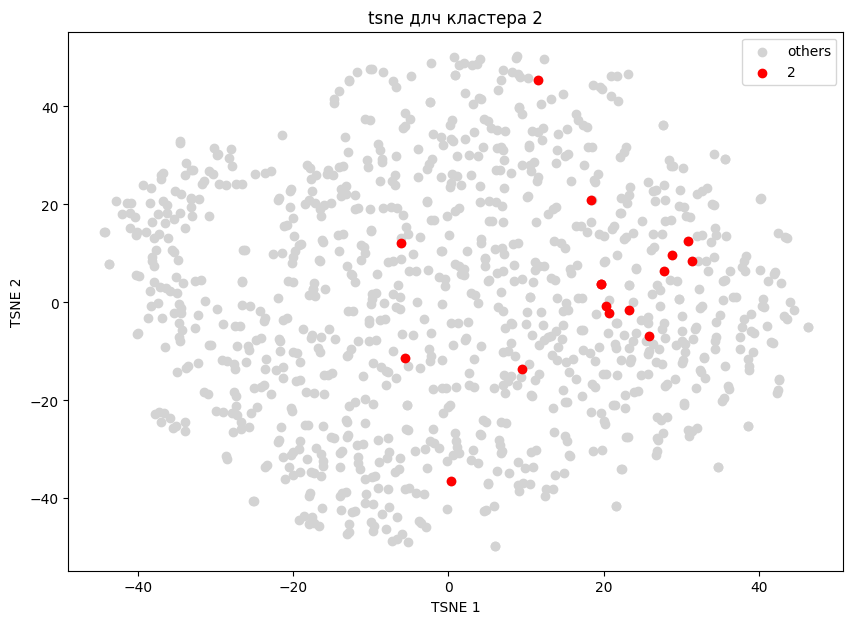

In [91]:
num = 2
mask = (kmeans.labels_ == num)

plt.figure(figsize=(10, 7))

plt.scatter(results[:, 0], results[:, 1], color='lightgray', label='others')
plt.scatter(results[mask, 0], results[mask, 1], color='red', label=f'{num}')

plt.title(f'tsne длч кластера 2')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend()
plt.show()

**Ответ:**

Заметим что точки большинтсов точек кластера разброасаны друг от друга, но есть и те которые расположены близко друг к другу